# Disparity Metrics

In [1]:
!pwd

/home/gangda/notebook/GNN-MoE Heuristics


In [2]:
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra

import torch
import torch.nn.functional as F
from torch_geometric.utils import spmm
import pandas as pd
from torch_scatter import scatter
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns
import os
import os.path as osp

ROOT_PATH = '/home/gangda/workspace/gnn-moe'
DATA_PATH = ROOT_PATH + '/DATA'
RES_PATH = ROOT_PATH + '/processed'
import sys
sys.path.append(ROOT_PATH)

from data import get_data
from disparity import get_node_homophily, get_degree, get_pagerank, get_clustering_coef, \
    get_neighborhood_confusion, get_directional_label_distance, get_intra_class_degree, \
    get_intra_class_neighborhood_feature_similarity, get_directional_label_cos_similarity, get_intra_class_neighborhood_label_similarity, get_directional_label_similarity, get_direction_informativeness, get_directionality, get_intra_class_directionality
from utils.utils import index_to_mask, group_values, adj_norm


sns.set_palette("tab10")
sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')


def load_data(_dataset, undirected=False):
    GlobalHydra.instance().clear()
    initialize(version_base=None, config_path="../../workspace/gnn-moe/conf")
    _data_conf = dict(compose(overrides=[f"+dataset={_dataset}"]).dataset)
    _data_conf['undirected'] = undirected
    return get_data(root=DATA_PATH+'/pyg', **_data_conf)


def convert_mask(_data):
    _train_mask = index_to_mask(_data.train_mask, size=_data.num_nodes).t()
    _val_mask = index_to_mask(_data.val_mask, size=_data.num_nodes).t()
    _test_mask = index_to_mask(_data.test_mask, size=_data.num_nodes).t()
    if _train_mask.dim() == 1:
        _train_mask = _train_mask.unsqueeze(0)
        _val_mask = _val_mask.unsqueeze(0)
        _test_mask = _test_mask.unsqueeze(0)
    return _train_mask, _val_mask, _test_mask


def plot_density_with_marginals(val1, val2, kind="kde", cmap=None, title="Density Plot with Marginals", xlabel="Metric 1", ylabel="Metric 2",stat=None):
    """
    Plots a 2D density plot with marginal distributions using Seaborn.

    Parameters:
        val1 (list or numpy array): The first metric values.
        val2 (list or numpy array): The second metric values.
        kind (str): The type of plot in the center ("kde", "scatter", or "hex").
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
    """
    # Create a jointplot
    g = sns.jointplot(
        x=val1,
        y=val2,
        kind=kind,
        marginal_ticks=True,
        # fill=True,
        # alpha=0.3,
        joint_kws={'cmap': cmap} if (kind in ["kde", "hex"] and cmap) else {},  # Apply colormap for kde/hex kinds
        marginal_kws={'fill': True}  # Smooth filling for marginal distributions
    )
    # Add labels and title
    g.set_axis_labels(xlabel, ylabel)
    plt.suptitle(title, y=1.02)
    # Set the spines visible
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1)
    # Display the plot
    plt.show()


def plot_concept_shift(n_concept, concept, concept_val, labels, upper_percentile, fig_size=(10, 6)):
    n_concept = n_concept
    truncate_concept = concept_val.clip(0, np.percentile(concept_val, upper_percentile)).to(torch.float32).numpy()
    truncate_concept += np.random.normal(0, 0.001, truncate_concept.shape)

    concept_groups = pd.qcut(truncate_concept, q=n_concept, labels=np.arange(n_concept))
    grouped_data = pd.DataFrame({
        concept: concept_groups,
        "val": truncate_concept,
        "label": labels
    })

    distribution = grouped_data.groupby([concept, "label"]).size().unstack(fill_value=0)
    distribution.plot(
        kind="bar",
        stacked=True,
        figsize=fig_size,
        colormap="viridis"
    )

    plt.title("Label Distribution by " + concept)
    plt.xlabel(concept)
    plt.ylabel("Count")
    plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [38]:
dataset = 'amazon_ratings'
# undirected = False
undirected = True
data, num_features, num_classes, dataset_dir = load_data(dataset, undirected=undirected)

data = data.to('cuda:0')
disparity_dict = {
    # 'pagerank': get_pagerank(data.adj_t.t()),
    # 'cluster': get_clustering_coef(data),
    'degree': get_degree(data.adj_t),
    'intra_degree': get_intra_class_degree(data),
    # 'homophily': get_node_homophily(data.adj_t, data.y),
    # 'homophily2': get_node_homophily(data.adj_t, data.y, hop=2),
    # # 'confusion': get_neighborhood_confusion(
    # #                 data, dataset, path=RES_PATH+'/disparities',
    # #                 return_nc=True, undirected=True),
    # 'feat_dist': get_intra_class_neighborhood_feature_similarity(data, return_all_classes=True),
    # 'intra_feat_dist': get_intra_class_neighborhood_feature_similarity(data),
    'feat_sim': get_intra_class_neighborhood_feature_similarity(data, return_all_classes=True),
    'intra_feat_sim': get_intra_class_neighborhood_feature_similarity(data),
    # 'intra_feat_sim_norm': get_intra_class_neighborhood_feature_similarity(data) / get_intra_class_neighborhood_feature_similarity(data, return_all_classes=True),
    # 'feat_cos_sim': get_intra_class_neighborhood_feature_similarity(data, cos=True, return_all_classes=True),
    # 'intra_feat_cos_sim': get_intra_class_neighborhood_feature_similarity(data, cos=True),
    # 'intra_feat_cos_sim_norm': get_intra_class_neighborhood_feature_similarity(data, cos=True) / get_intra_class_neighborhood_feature_similarity(data, cos=True, return_all_classes=True),
    'label_sim': get_intra_class_neighborhood_label_similarity(data, return_all_classes=True),
    'intra_label_sim': get_intra_class_neighborhood_label_similarity(data),
    # 'intra_label_sim_norm': get_intra_class_neighborhood_label_similarity(data)/get_intra_class_neighborhood_label_similarity(data, return_all_classes=True),
    # 'label_cos_sim': get_intra_class_neighborhood_label_similarity(data, cos=True, return_all_classes=True),
    # 'intra_label_cos_sim': get_intra_class_neighborhood_label_similarity(data, cos=True),
}

if not undirected:
    disparity_dict['dir_label_dist'] = get_directional_label_distance(data)
    disparity_dict['dir_label_sim'] = get_directional_label_similarity(data)
    disparity_dict['dir_label_cos_sim'] = get_directional_label_cos_similarity(data)
    disparity_dict['dir'] = get_directionality(data)
    disparity_dict['intra_dir'] = get_intra_class_directionality(data)

<Axes: ylabel='Count'>

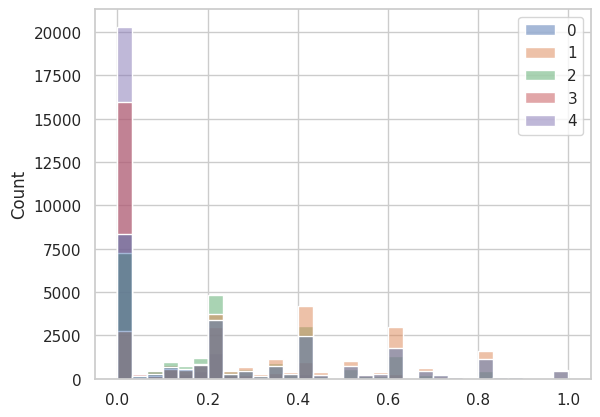

In [4]:
y = F.one_hot(data.y).to(torch.float)
neigh_y = spmm(data.adj_t.to_symmetric(), y, reduce='mean')

sns.histplot(neigh_y.cpu(), bins=30, kde=False)

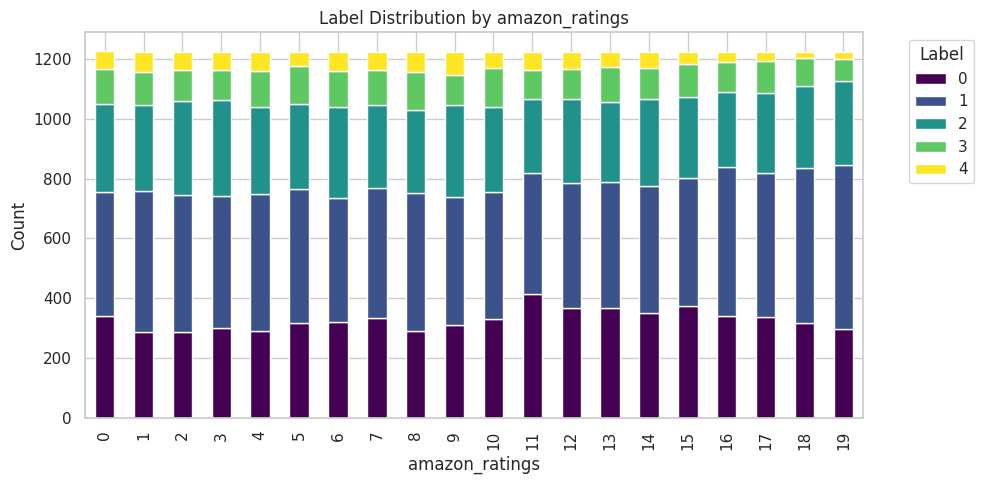

In [5]:
# for _dataset in ['arxiv-year', 'snap-patents',]:
# for _dataset in ['arxiv', 'amazon_ratings', 'flickr', 'penn94']:
for _dataset in ['amazon_ratings']:
    # _data, _, _, _ = load_data(_dataset, undirected=False)
    # concept_val = get_directionality(_data)

    _data, _, _, _ = load_data(_dataset, undirected=True)
    concept_val = get_degree(_data.adj_t)
    # concept_val = get_intra_class_degree(_data)
    
    # concept_val = get_intra_class_neighborhood_feature_similarity(_data, cos=True)
    # concept_val = get_intra_class_neighborhood_label_similarity(_data)

    n_concept = 20
    concept = _dataset
    upper_percentile = 95
    fig_size = (10,5)
    plot_concept_shift(n_concept, concept, concept_val, _data.y, upper_percentile, fig_size)

    # sns.histplot(concept_val.clip(0, np.percentile(concept_val, upper_percentile)), bins=30, kde=False)

# Plot Expert Performance 

In [6]:
train_mask, val_mask, test_mask = convert_mask(data)
r = train_mask.size(0)

## Load Model ACCs
model_dict = {
    'chameleon': {
        'GCN': '-undir_GCN-jkLAST-resSUM-dropout0.7',
        'MixHop': '-undir_MIXHOP-jkLAST-resSUM-dropout0.7',
        'DirGCN': '_DIRGCN-jkLAST-resCAT-dropout0.6',
    },
    'squirrel': {
        'MLP': '_MLP-resSUM-dropout0.5-init1_conv3',
        'GCN': '-undir_GCN-jkLAST-resCAT-dropout0.6',
        'DirGCN': '_DIRGCN-jkLAST-resCAT-dropout0.6-init1',
    },
    'amazon_ratings': {
        'MLP': '_MLP-resSUM-dropout0.2-init1_conv3',
        'GCN': '_GCN-jkLAST-resCAT-dropout0.5-init1',
        'DirGCN': '_DIRGCN-jkLAST-resCAT-dropout0.5-init1',
        'GCN-rw': '_GCNNORM-jkLAST-resCAT-dropout0.5-init1-rw',
        'GCN-src': '_GCNNORM-jkLAST-resCAT-dropout0.5-init1-src',
    },
    'arxiv': {
        'MLP': '_MLP-dropout0.2_conv3',
        'GCN': '_GCN-resCAT-dropout0.5',
        # 'GCN-rw': '_GCNNORM-resCAT-dropout0.5-rw',
        # 'GCN-src': '_GCNNORM-resCAT-dropout0.5-src',
        'GCN-rw': '_GCNNORM-dropout0.5-rw',
        'GCN-src': '_GCNNORM-dropout0.5-src',
    },
    'arxiv-year': {
        'MLP': '_MLP-resSUM-dropout0.5-init1_conv3',
        'GCN': '_GCN-dropout0.5_conv5',
        'GCN-rev': '_GCN-dropout0.5_conv4_revADJ',
        'GAT': '_GAT-dropout0.5_conv3',
        'GAT-rev': '_GAT-dropout0.5_conv4_revADJ',
        'DirGCN': '_DIRGCN-jkLAST-dropout0.3_conv6',
    },
    'genius': {
        'GCN': '_GCN-resCAT-init1',
        'DirGCN': '_DIRGCN-resCAT-init1',
    },
    'snap-patents': {
        'DirGCN': '_DIRGCN-jkMAX-resCAT',
        'Faber': '_FABER-jkMAX-resCAT',
    }
}


def load_acc(_dataset, _model, _model_dict, _data, trial='trial_default'):
    _logit = torch.load(osp.join(str(RES_PATH), trial, 'logit/{}{}.pt'.format(
        _dataset, _model_dict[_dataset][_model]))).to(_data.y.device)
    if _logit.shape[-1] == 1:
        _acc = (_logit > 0).squeeze() == _data.y
    else:
        _acc = _logit.argmax(dim=-1) == _data.y
    return _acc.float()

In [7]:
disparity_dict['intra_label_sim_deg'] = disparity_dict['intra_label_sim'] / disparity_dict['degree']
disparity_dict['intra_feat_cos_sim_deg'] = disparity_dict['intra_feat_cos_sim'] / disparity_dict['degree']

tensor([ 5.0000,  5.0000,  5.0000,  5.0000,  5.0000,  5.0000,  6.0000,  7.1000,
        10.0000, 20.3000], device='cuda:0')

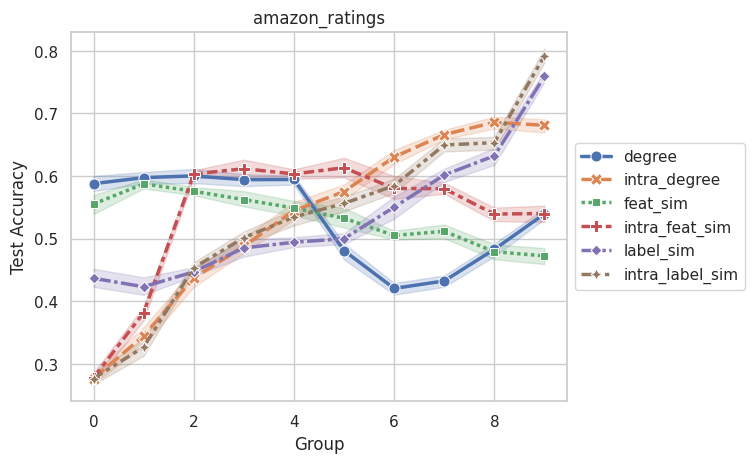

In [39]:
num_groups = 10
models = ['GCN']
group_by = 'sample'
disparity_metrics = ['degree', 'intra_degree', 'feat_sim', 'intra_feat_sim', 'label_sim', 'intra_label_sim']
# disparity_metric = 'intra_class_degree'
# disparity_metric = 'feat_dist'
# disparity_metric = 'intra_feat_dist'
# disparity_metric = 'feat_sim'
# disparity_metric = 'intra_feat_sim'
# disparity_metric = 'intra_feat_sim_norm'
# disparity_metric = 'feat_cos_sim'
# disparity_metric = 'intra_feat_cos_sim'
# disparity_metric = 'intra_feat_cos_sim_norm'
# disparity_metric = 'label_sim'
# disparity_metric = 'intra_label_sim'
# disparity_metric = 'intra_label_sim_norm'
# disparity_metric = 'label_cos_sim'
# disparity_metric = 'intra_label_cos_sim'

# disparity_metric = 'intra_label_sim_deg'
# disparity_metric = 'intra_feat_cos_sim_deg'

grouped_disparity_arr = []
acc_arr, homo_group_arr, metrics = [], [], []
model = models[0]
# for i, model in enumerate(models):
for i, metric in enumerate(disparity_metrics):
    acc = load_acc(dataset, model, model_dict, data)
    # acc = load_acc(dataset, model, model_dict, data, trial='')
    
    if acc.dim() == 1:
        acc = acc.unsqueeze(0)
    
    for run in range(10): 
        test_mask_run = test_mask[run % r]
        
        group_disparity, group_idx, sort_indices = group_values(
            disparity_dict[metric][test_mask_run], 
            # (disparity_dict[metric]/disparity_dict['confusion'])[test_mask_run], 
            num_groups, group_by=group_by
        )
        acc_run = acc[run, test_mask_run][sort_indices]
        acc_arr.append(scatter(acc_run, group_idx, reduce='mean'))
        # if group_by == 'domain':
        #     homo_group_arr += group_disparity.tolist()
        # else:
        #     homo_group_arr += list(range(num_groups))
        homo_group_arr += list(range(num_groups))
        metrics += [metric] * num_groups
        
        if i == 0:
            grouped_disparity_arr.append(group_disparity)


df = pd.DataFrame({
    metric: homo_group_arr, 
    'Metric': metrics,
    # 'Model': gnns,
    'Accuracy': torch.cat(acc_arr).cpu(),
})

g_1 = sns.lineplot(
    x=metric, 
    y='Accuracy', 
    hue='Metric', 
    style="Metric", 
    data=df,
    markers=True, 
    markersize=8,
    linewidth=2.5,
)
g_1.set_ylabel('Test Accuracy')
g_1.set_xlabel(f'Group')
# g_1.set_ylim(0.15, 1.03)
# g_1.set_ylim(0.1, 0.87)
g_1.set_title(f'{dataset}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

torch.stack(grouped_disparity_arr, dim=0).float().mean(dim=0)

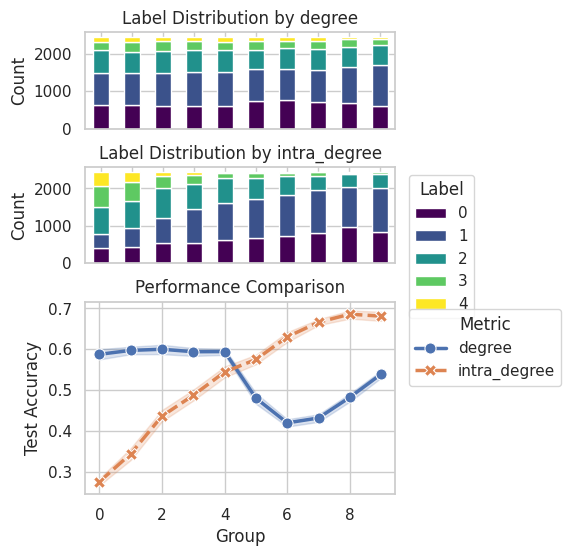

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

sns.set_theme(style="whitegrid")

# --- 准备参数 ---
metrics = ['degree', 'intra_degree']
num_bins   = 10
upper_pct  = 95

# 假设你之前用相同方式累积了这三个列表：
# homo_group_arr: list of length num_bins*2*#runs，依次是 10 个 degree 分组 + 10 个 intra_degree 分组（每 run）
# metrics_perf : list of 同样长度，元素为 'degree' 或 'intra_degree'
# acc_arr      : list of 同样长度，对应各组的平均 Accuracy
#（如果是 torch.Tensor，可以用 .cpu().numpy() 转成 numpy）
metrics_perf = []
for m in disparity_metrics:
    # 每个 metric 会在每个 run、每个组出现一次：
    metrics_perf += [m] * (10 * num_groups)

# --- 创建 3x1 的网格，给底部曲线图更大的空间 ---
fig, axes = plt.subplots(
    nrows=3, ncols=1,
    figsize=(4, 6),
    gridspec_kw={'height_ratios': [1, 1, 2], 'hspace':0.3}
)

# --- 前两个子图：Label Distribution ---
for ax, metric in zip(axes[:2], metrics):
    # 1) 取出原始指标值并截断到第 upper_pct 百分位
    vals = disparity_dict[metric].cpu().numpy()
    trunc = np.clip(vals, 0, np.percentile(vals, upper_pct))
    # 可选抖动
    trunc += np.random.normal(scale=1e-3, size=trunc.shape)

    # 2) 按 quantile 切到 num_bins 段
    groups = pd.qcut(trunc, q=num_bins, labels=np.arange(num_bins))
    df_dist = pd.DataFrame({
        metric: groups,
        'label': data.y.cpu().numpy()
    })

    # 3) 分组计数并画堆叠柱状图
    counts = df_dist.groupby([metric, 'label']).size().unstack(fill_value=0)
    counts.plot(
        kind='bar',
        stacked=True,
        ax=ax,
        colormap='viridis',
        legend=False   # 先关掉，最后统一放
    )
    ax.set_ylabel('Count')
    ax.set_xlabel('')
    ax.set_title(f'Label Distribution by {metric}')
    ax.set_xticklabels([])  # 用数字做刻度可视化不重要

# 在第二个子图右侧加一个统一的图例
axes[1].legend(handles, labels, title='Label',
               bbox_to_anchor=(1.02, 1), loc='upper left')

# --- 第三个子图：Performance 曲线 ---
df_perf = pd.DataFrame({
    'Group':    homo_group_arr,
    'Metric':   metrics_perf,
    'Accuracy': torch.cat(acc_arr).cpu(),
})

sns.lineplot(
    x='Group', y='Accuracy',
    hue='Metric', style='Metric',
    markers=True, markersize=8,
    linewidth=2.5,
    data=df_perf,
    ax=axes[2]
)
axes[2].set_xlabel('Group')
axes[2].set_ylabel('Test Accuracy')
axes[2].set_title('Performance Comparison')
axes[2].legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

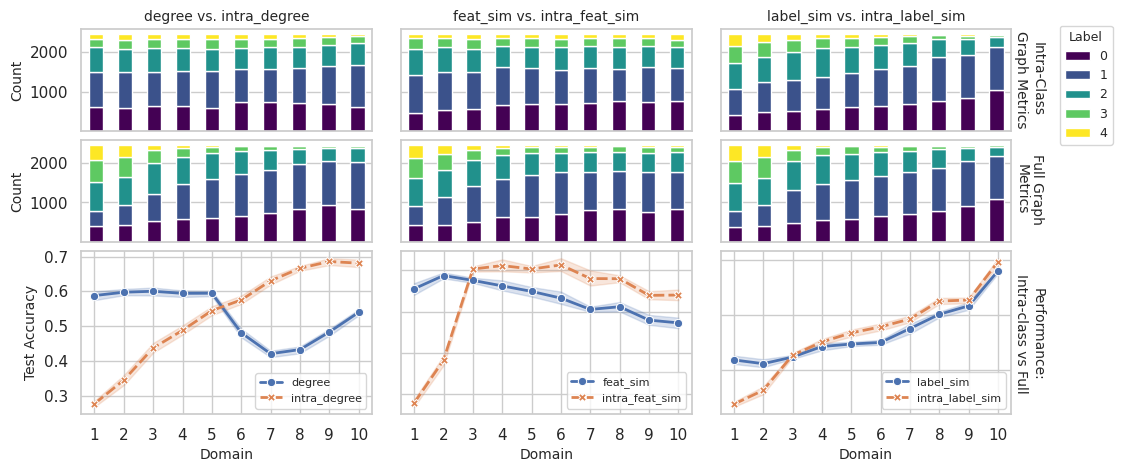

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

sns.set_theme(style="whitegrid")

# --- 定义你的三组 pair ---
pairs = [
    ('degree', 'intra_degree'),
    ('feat_sim', 'intra_feat_sim'),
    ('label_sim', 'intra_label_sim'),
]

num_bins  = 10
upper_pct = 95
num_runs  = 10  # 你实际的 runs 数
num_groups = num_bins

# 先把整个 df_perf 拼好
acc_np = torch.cat(acc_arr, dim=0).cpu().numpy()
metrics_full = []
for m in [m for pair in pairs for m in pair]:
    # 每个 metric 会在每个 run、每个组出现一次
    metrics_full += [m] * (num_runs * num_groups)

df_perf = pd.DataFrame({
    'Group':    homo_group_arr,
    'Metric':   metrics_full,
    'Accuracy': acc_np,
})
df_perf['Group'] = df_perf['Group'] + 1

# --- 创建 3×3 网格 ---
fig, axes = plt.subplots(
    nrows=3, ncols=3,
    figsize=(12, 5),
    gridspec_kw={
        'height_ratios': [1, 1, 1.6], 
        'wspace': 0.1,   # 列间距
        'hspace': 0.07   # 行间距
    }
)

for col, (m1, m2) in enumerate(pairs):
    # 上：metric1 的分布
    ax = axes[0, col]
    vals = disparity_dict[m1].cpu().numpy()
    trunc = np.clip(vals, 0, np.percentile(vals, upper_pct))
    trunc += np.random.normal(scale=1e-3, size=trunc.shape)
    grp = pd.qcut(trunc, q=num_bins, labels=np.arange(num_bins))
    dfd = pd.DataFrame({m1: grp, 'label': data.y.cpu().numpy()})
    counts = dfd.groupby([m1, 'label']).size().unstack(fill_value=0)
    counts.plot(
        kind='bar', stacked=True, ax=ax, colormap='viridis', legend=False
    )
    # ax.set_title(f'Distribution of {m1}', fontsize=10)
    axes[0, col].set_title(
        # f'Distributions of {m1} (top) vs. {m2} (middle)',
        f'{m1} vs. {m2}',
        fontsize=10
    )
    ax.set_xlabel(''); 
    # 只在第一列显示 y 轴
    if col == 0:
        ax.set_ylabel('Count', fontsize=10)
        ax.set_yticks([1000, 2000])
    else:
        ax.tick_params(labelleft=False)   # 隐藏刻度标签
        ax.set_ylabel('')
    # ax.set_ylabel('Count')
    ax.set_xticks([])

    # 中：metric2 的分布
    ax = axes[1, col]
    vals = disparity_dict[m2].cpu().numpy()
    trunc = np.clip(vals, 0, np.percentile(vals, upper_pct))
    trunc += np.random.normal(scale=1e-3, size=trunc.shape)
    grp = pd.qcut(trunc, q=num_bins, labels=np.arange(num_bins))
    dfd = pd.DataFrame({m2: grp, 'label': data.y.cpu().numpy()})
    counts = dfd.groupby([m2, 'label']).size().unstack(fill_value=0)
    counts.plot(
        kind='bar', stacked=True, ax=ax, colormap='viridis', legend=False
    )
    # ax.set_title(f'Distribution of {m2}', fontsize=10)
    ax.set_xlabel(''); 
    # 只在第一列显示 y 轴
    if col == 0:
        ax.set_ylabel('Count', fontsize=10)
        ax.set_yticks([1000, 2000])
    else:
        ax.tick_params(labelleft=False)   # 隐藏刻度标签
        ax.set_ylabel('')
    # ax.set_ylabel('Count')
    ax.set_xticks([])

    # 下：同一列里的两条性能曲线
    ax = axes[2, col]
    ax.set_xticks(range(1, 11))
    df_sub = df_perf[df_perf['Metric'].isin([m1, m2])]
    sns.lineplot(
        x='Group', y='Accuracy',
        hue='Metric', style='Metric',
        markers=True, markersize=6, linewidth=2,
        data=df_sub, ax=ax
    )
    # ax.set_title(f'Performance: {m1} vs {m2}', fontsize=10)
    ax.set_xlabel('Domain', fontsize=10)
    # y 轴同理：只有第一列有标签
    if col == 0:
        ax.set_ylabel('Test Accuracy', fontsize=10)
    else:
        ax.tick_params(labelleft=False)
        ax.set_ylabel('')
    # ax.set_ylabel('Accuracy')
    ax.legend(
              # title='Metric', 
              loc='lower right', 
              fontsize=8,        # 图例文字大小
              title_fontsize=9   # 图例标题大小
             )


handles, labels = axes[0, 0].get_legend_handles_labels()
# 2a) 全局放一个图例（放在 figure 的右上角）
fig.legend(
    handles, labels,
    title='Label',
    bbox_to_anchor=(0.935, 0.9),  # 你可以调这个位置
    loc='upper left',
    fontsize=9,        # 图例文字大小
    title_fontsize=9,   # 图例标题大小
)

# title for row 0 only:
fig.text(0.915, 0.78, "Intra-Class\nGraph Metrics", va="center", ha="center",
         rotation=270, fontsize=10)

# title for row 1 only:
fig.text(0.915, 0.56, "Full Graph\nMetrics", va="center", ha="center",
         rotation=270, fontsize=10)

# title for row 2 only:
fig.text(0.915, 0.27, "Performance:\nIntra-class vs Full", va="center", ha="center",
         rotation=270, fontsize=10)

# 最后调整一下整体布局
plt.tight_layout()
plt.show()

fig.savefig("amazon_ratings_performance_disparity_and_concept_shift.pdf", bbox_inches="tight")